In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
from sklearn.neural_network import MLPRegressor
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from PredictXANES import xanes_derivatives

In [3]:
def split_data(df, size):
    '''
    The spectra are split into a training set and 
    testing set with a ratio of the size_list. The predicted features are the coordination number, 
    number of Cu atoms, and number of Te atoms.
    '''
    
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])
    X.columns = list
   
    y = df[['CN', 'Num Cu', 'Num Te']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=12)
    
    return X_train, X_test, y_train, y_test, X, y

def derivatives(X):
    '''
    Calculates and returns the first and second derivative of the spectra
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = pd.concat([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dmu1_2

    
def train(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(lossdf)
    return lossdf, nn

#average wrapper function
    '''
    This will average the best epochs for each hidden layer
    '''
def analyse_layer(X_train, X_test, y_train, y_test, nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = nn.predict(X_train)
    y_test_pred = nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_parity(y_test, y_test_pred):
    '''
    plot_parity is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf, nn = train(X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, nn) #series from dataframe
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_parity(y_test, y_test_pred)

def MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, 
                     rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for spectrum
    '''
    for entry in size_list:
        print('training set percent', entry)
        X_train, X_test, y_train, y_test, X, y = split_data(df, entry)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                  score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

def MLP_per_set_size_1(df, size_list, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                       rmse_Te_i_list_1, score_Te_i_list_1):
    '''
    MLP_per_noise_1 is a wrapper function that runs a layer of neural network per level of noise for the 
    first derivative
    '''
    for entry in size_list:
        print('training set percent', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df1, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                  score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
          score_Te_i_list_1)

def MLP_per_set_size_2(df, size_list, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                       rmse_Te_i_list_2, score_Te_i_list_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for the second 
    derivative
    '''
    for entry in size_list:
        print('training set percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df2, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
          score_Te_i_list_2)
    
    
def MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                         score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise for both 
    the first and second derivative
    '''
    for entry in size_list:
        print('training set percent: ', entry)
        _, _, _, _, X, y = split_data(df, entry)
        df1, df2, df3, = derivatives(X)
        X_train, X_test, y_train, y_test = train_test_split(df3, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                  score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
          score_Te_i_list_1_2)

def average_scores_spectra(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df
    
def compile_score_lists_spectra(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_spectra(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df
    
def compile_score_lists_1(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df
    
def compile_score_lists_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df
    
def compile_score_lists_1_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_set_size_1_2(df, size_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 


Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [4]:
df = pd.read_csv('mu_cn1000_energies.csv')

## Spectra Only:

Create lists for plotting noise vs R2 and RMSE

In [5]:
size_list = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
iterations = 20

set size:  0.9
           0
0   0.025582
1   0.001340
2   0.001306
3   0.001290
4   0.001888
5   0.001886
6   0.001470
7   0.002011
8   0.001437
9   0.001817
10  0.001776
11  0.001375
12  0.001936
13  0.001535
14  0.001341
15  0.001285
16  0.001916
17  0.002030
18  0.001432
19  0.001885
20  0.001357
21  0.001879
22  0.001403
23  0.001803
24  0.001354
25  0.001301
26  0.001345
27  0.001803
28  0.002037
29  0.001421
30  0.001299
31  0.001664
32  0.001278
33  0.001301
34  0.001903
35  0.001750
36  0.001624
37  0.001876
38  0.001740
39  0.001895
40  0.001415
41  0.001906
42  0.001369
43  0.001532
44  0.001235
45  0.001839
46  0.001310
47  0.001325
48  0.001430
49  0.001967
50  0.001689
51  0.001724
52  0.001874
53  0.001844
54  0.001864
55  0.001634
56  0.001700
57  0.001846
58  0.001798
59  0.001332
60  0.001385
61  0.001764
62  0.001328
63  0.001894
64  0.001660
65  0.001870
66  0.001865
67  0.001331
68  0.001378
69  0.001779
70  0.001814
71  0.001922
72  0.001315
73  0.001204
74  0.0014

           0
0   0.008759
1   0.001846
2   0.001349
3   0.001910
4   0.001820
5   0.001796
6   0.001805
7   0.001472
8   0.001274
9   0.001443
10  0.001761
11  0.001962
12  0.001785
13  0.001428
14  0.001305
15  0.001377
16  0.001837
17  0.001950
18  0.002077
19  0.001779
20  0.001422
21  0.001364
22  0.001296
23  0.001336
24  0.001811
25  0.001799
26  0.001824
27  0.001713
28  0.001282
29  0.001776
30  0.001800
31  0.001735
32  0.001796
33  0.001782
34  0.001305
35  0.001813
36  0.001445
37  0.001726
38  0.001241
39  0.001812
40  0.001263
41  0.001312
42  0.001449
43  0.001812
44  0.001345
45  0.001787
46  0.001265
47  0.001665
48  0.001648
49  0.001662
50  0.001813
51  0.001242
52  0.001762
53  0.001748
54  0.001739
55  0.001443
56  0.001278
57  0.001661
58  0.001745
59  0.001777
60  0.001263
61  0.001807
62  0.001281
63  0.001801
64  0.001774
65  0.001734
66  0.001206
67  0.001814
68  0.001801
69  0.001184
70  0.001775
71  0.001806
72  0.001785
73  0.001219
74  0.001309
75  0.001797

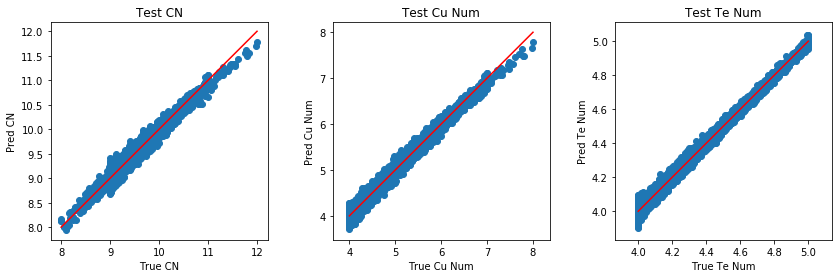

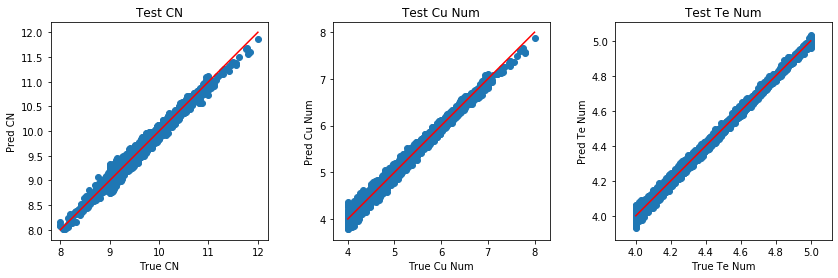

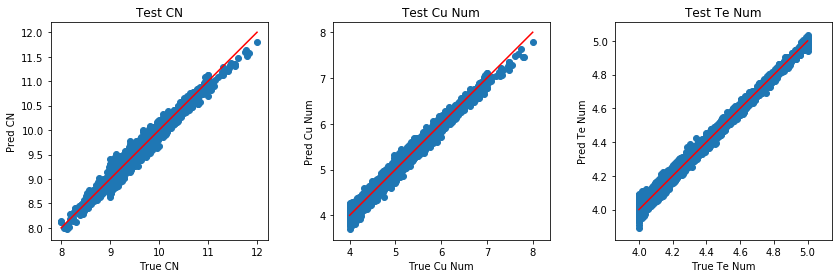

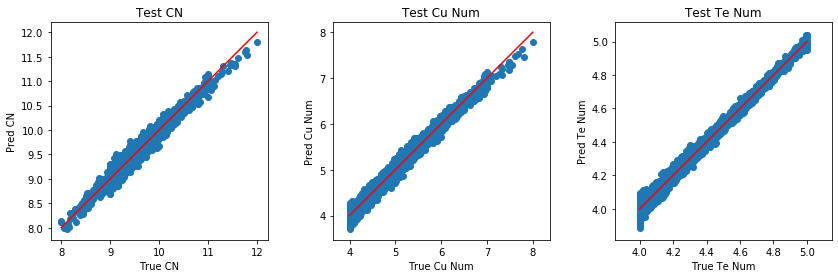

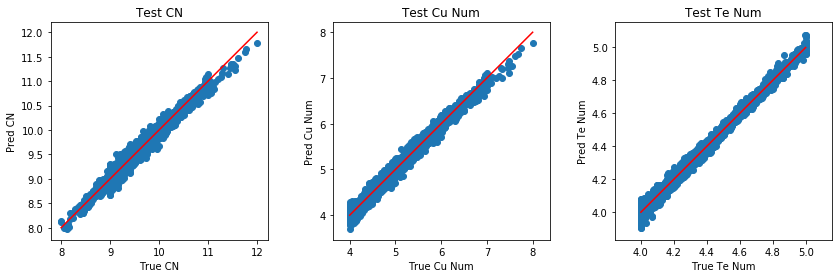

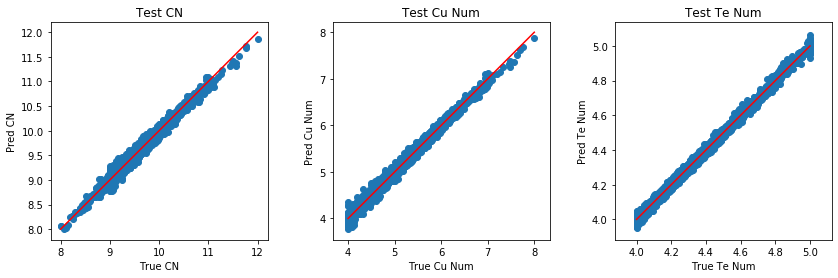

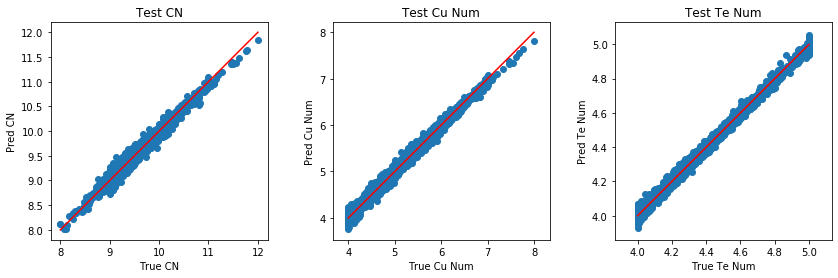

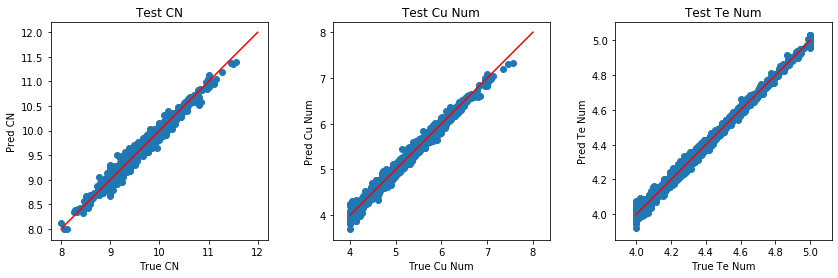

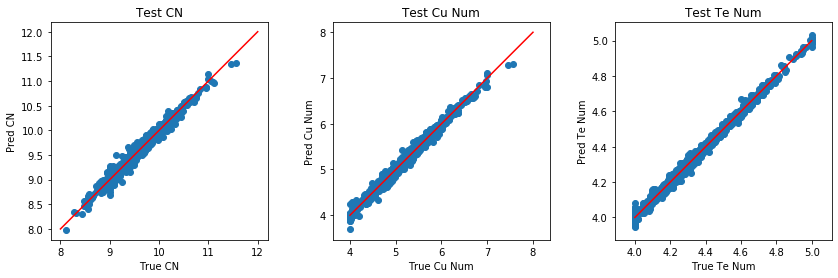

In [6]:
average_scores_spectra(iterations, df, Noise_STD)

# Repeated for training with first derivative.

set size:  0.9
           0
0   0.007603
1   0.000400
2   0.000544
3   0.000442
4   0.000585
5   0.000446
6   0.000491
7   0.000503
8   0.000487
9   0.000543
10  0.000534
11  0.000658
12  0.000550
13  0.000698
14  0.000625
15  0.000389
16  0.000458
17  0.000523
18  0.000607
19  0.000610
20  0.000583
21  0.000615
22  0.000460
23  0.000518
24  0.000512
25  0.000381
26  0.000569
27  0.000524
28  0.000898
29  0.000415
30  0.000670
31  0.000624
32  0.000624
33  0.000676
34  0.000530
35  0.000470
36  0.000531
37  0.000964
38  0.000593
39  0.000623
40  0.000550
41  0.000606
42  0.000384
43  0.000449
44  0.000981
45  0.000517
46  0.000696
47  0.000609
48  0.000487
49  0.000590
50  0.000708
51  0.000574
52  0.000471
53  0.000632
54  0.000579
55  0.000900
56  0.000631
57  0.000974
58  0.000673
59  0.000628
60  0.000989
61  0.000883
62  0.001000
63  0.000402
64  0.000471
65  0.000522
66  0.000983
67  0.000667
68  0.000968
69  0.000470
70  0.000881
71  0.000941
72  0.000991
73  0.000947
74  0.0006

           0
0   0.007518
1   0.000363
2   0.000523
3   0.000636
4   0.000556
5   0.000483
6   0.000370
7   0.000489
8   0.000592
9   0.000649
10  0.000447
11  0.000548
12  0.000669
13  0.000567
14  0.000480
15  0.000540
16  0.000374
17  0.000471
18  0.000370
19  0.000616
20  0.000429
21  0.000564
22  0.000386
23  0.000497
24  0.000499
25  0.000525
26  0.000460
27  0.000605
28  0.000716
29  0.000400
30  0.000418
31  0.000669
32  0.000708
33  0.000408
34  0.000709
35  0.000971
36  0.000857
37  0.000403
38  0.000702
39  0.000633
40  0.000741
41  0.000464
42  0.000459
43  0.000437
44  0.001016
45  0.000917
46  0.000464
47  0.000476
48  0.000475
49  0.000653
50  0.000438
51  0.000996
52  0.000974
53  0.000576
54  0.000459
55  0.000401
56  0.000773
57  0.000893
58  0.000974
59  0.000446
60  0.000468
61  0.001005
62  0.000407
63  0.000551
64  0.000471
65  0.001017
66  0.000991
67  0.001051
68  0.000940
69  0.000623
70  0.000975
71  0.000648
72  0.000542
73  0.000931
74  0.000967
75  0.000918

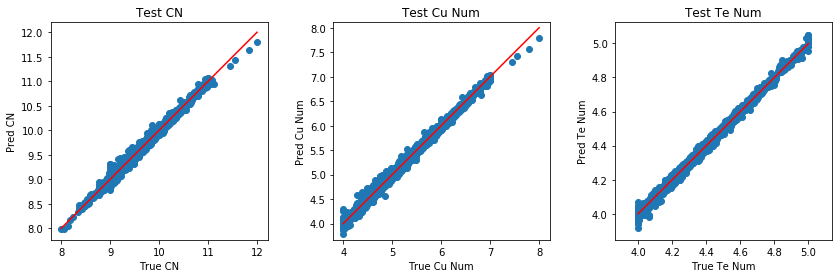

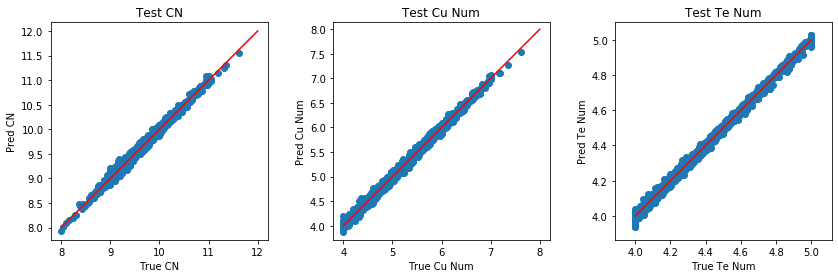

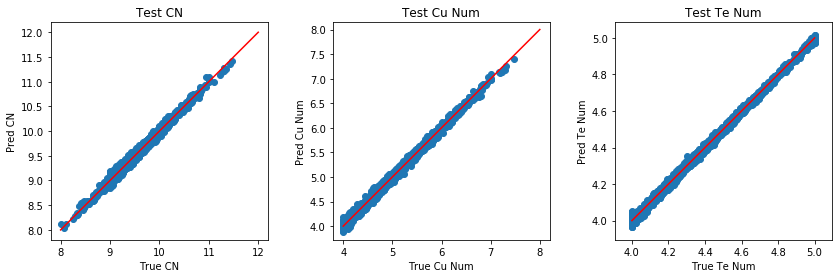

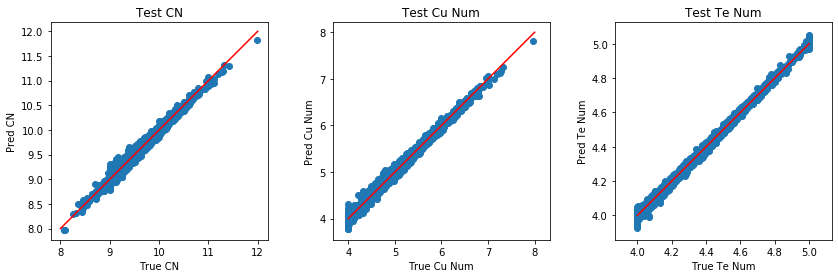

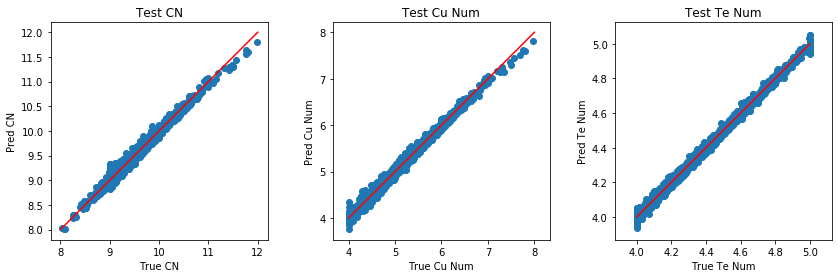

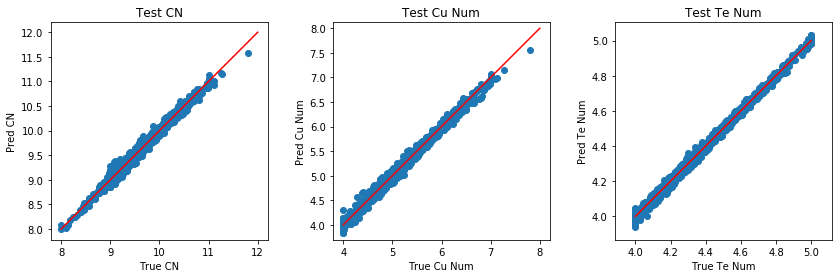

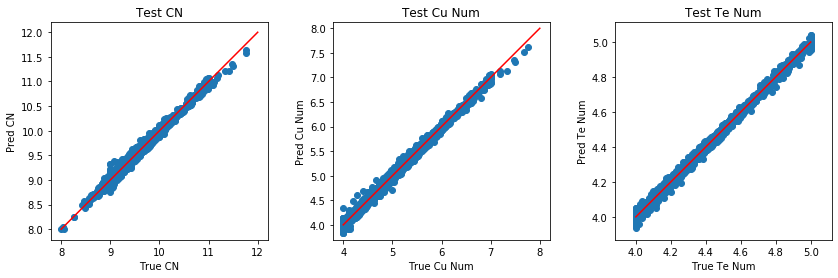

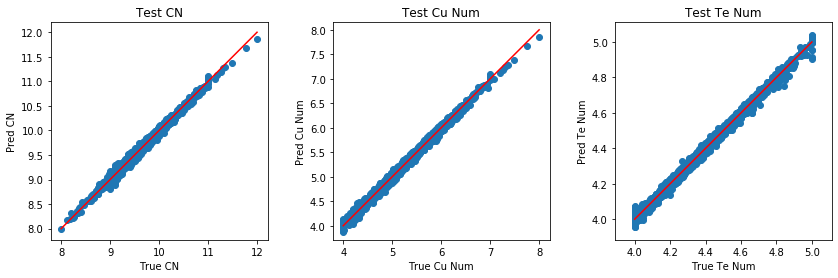

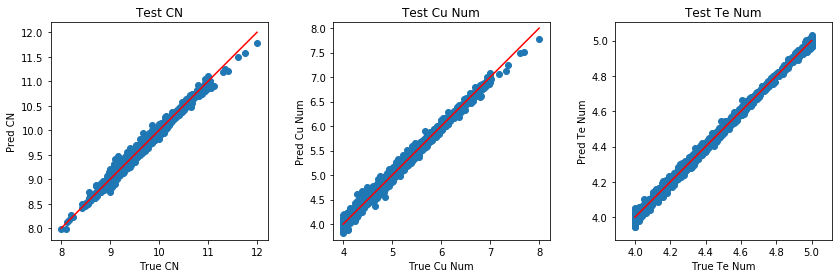

In [8]:
average_scores_1(iterations, df, Noise_STD)

# Repeated for training with second derivative.

set size:  0.9
           0
0   0.007934
1   0.000812
2   0.000678
3   0.000937
4   0.000941
5   0.001132
6   0.000799
7   0.000974
8   0.000785
9   0.000944
10  0.000997
11  0.000764
12  0.001095
13  0.001005
14  0.001021
15  0.001063
16  0.001083
17  0.000939
18  0.000724
19  0.000721
20  0.000966
21  0.000930
22  0.000937
23  0.000928
24  0.000902
25  0.000939
26  0.001364
27  0.001006
28  0.000945
29  0.000963
30  0.000901
31  0.000851
32  0.000897
33  0.001178
34  0.001151
35  0.000777
36  0.001116
37  0.000881
38  0.000867
39  0.000860
40  0.001359
41  0.001057
42  0.001209
43  0.000870
44  0.000844
45  0.001528
46  0.000874
47  0.001313
48  0.000857
49  0.000868
50  0.000918
51  0.001046
52  0.000960
53  0.001064
54  0.001068
55  0.001025
56  0.000646
57  0.000681
58  0.001022
59  0.000820
60  0.001023
61  0.000933
62  0.001495
63  0.001018
64  0.001086
65  0.000960
66  0.001105
67  0.001180
68  0.000854
69  0.001049
70  0.001515
71  0.001417
72  0.001033
73  0.000891
74  0.0009

           0
0   0.008724
1   0.000853
2   0.000897
3   0.000869
4   0.001571
5   0.000790
6   0.001047
7   0.001020
8   0.000778
9   0.000776
10  0.000905
11  0.000967
12  0.001037
13  0.000907
14  0.001190
15  0.001032
16  0.001493
17  0.000989
18  0.000834
19  0.000930
20  0.000869
21  0.000752
22  0.001013
23  0.000925
24  0.000753
25  0.000844
26  0.000815
27  0.001115
28  0.001013
29  0.000901
30  0.000842
31  0.000936
32  0.000770
33  0.001459
34  0.000970
35  0.000829
36  0.000972
37  0.000958
38  0.001085
39  0.001050
40  0.000973
41  0.000947
42  0.001158
43  0.001168
44  0.000934
45  0.001251
46  0.000794
47  0.001153
48  0.000804
49  0.000906
50  0.000779
51  0.000793
52  0.000964
53  0.000961
54  0.000879
55  0.000965
56  0.000882
57  0.001258
58  0.000639
59  0.000847
60  0.000970
61  0.000822
62  0.000869
63  0.000935
64  0.001327
65  0.000683
66  0.000869
67  0.001013
68  0.000939
69  0.001562
70  0.000845
71  0.001283
72  0.000902
73  0.000861
74  0.001064
75  0.001310

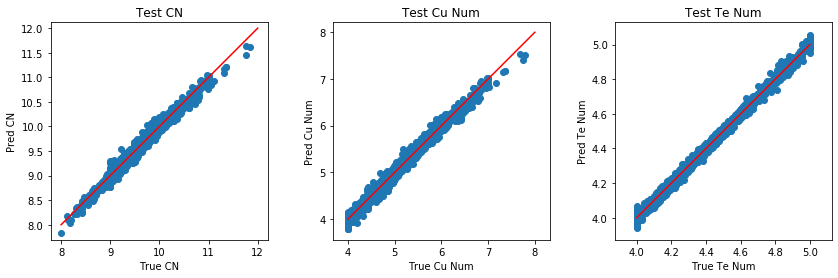

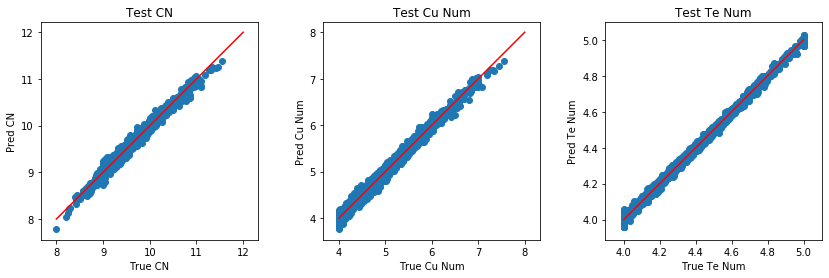

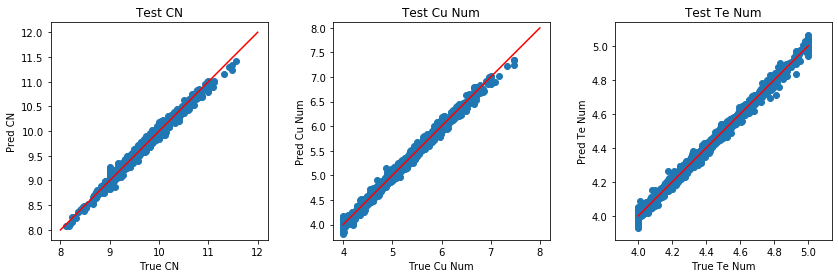

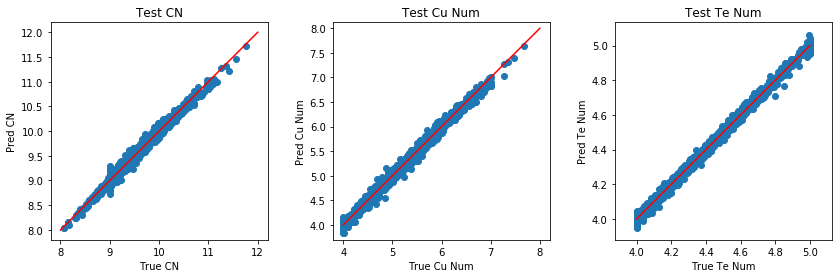

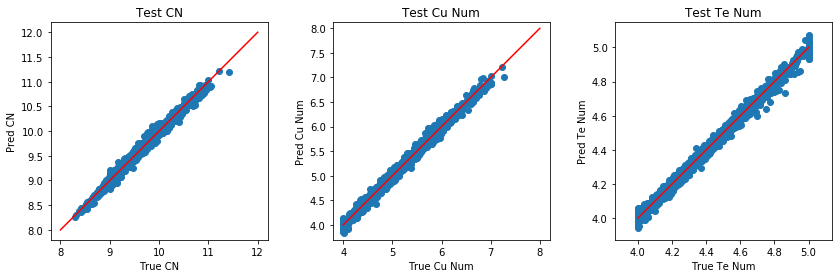

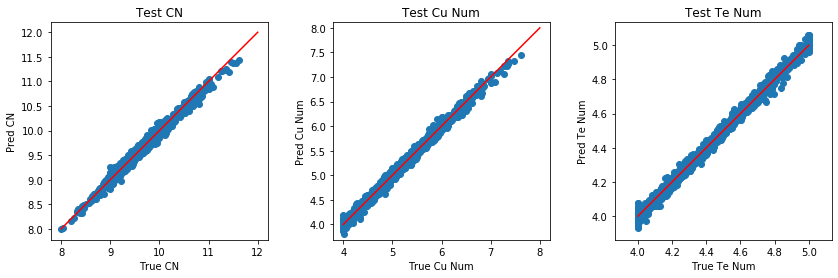

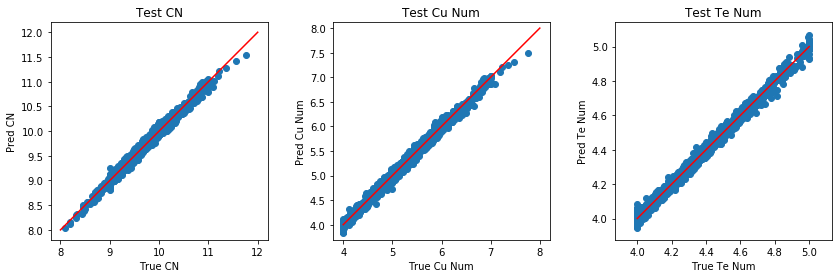

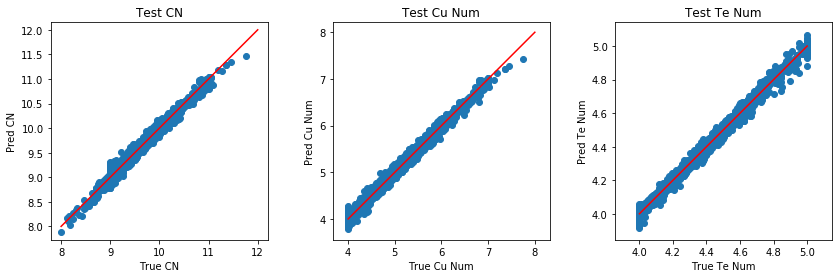

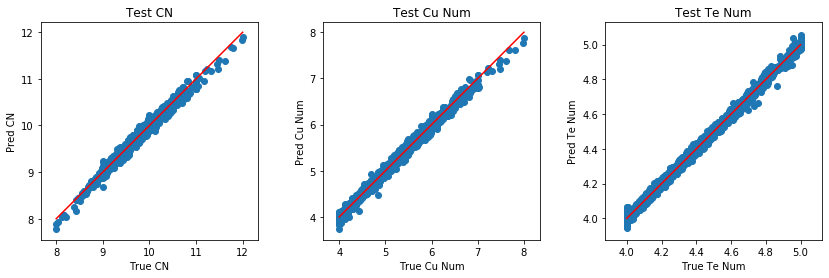

In [13]:
average_scores_2(iterations, df, Noise_STD)

# Repeated for training with both the first and second derivative.

set size:  0.9
           0
0   0.008176
1   0.000376
2   0.000335
3   0.000392
4   0.000551
5   0.000333
6   0.000410
7   0.000407
8   0.000340
9   0.000352
10  0.000553
11  0.000339
12  0.000415
13  0.000346
14  0.000500
15  0.000353
16  0.000373
17  0.000353
18  0.000490
19  0.000524
20  0.000523
21  0.000337
22  0.000493
23  0.000545
24  0.000380
25  0.000460
26  0.000347
27  0.000487
28  0.000416
29  0.000529
30  0.000486
31  0.000394
32  0.000379
33  0.000434
34  0.000560
35  0.000556
36  0.000543
37  0.000503
38  0.000507
39  0.000534
40  0.000490
41  0.000388
42  0.000727
43  0.000473
44  0.000533
45  0.000409
46  0.000415
47  0.000541
48  0.000582
49  0.000459
50  0.000467
51  0.000529
52  0.000525
53  0.000565
54  0.000446
55  0.000576
56  0.000501
57  0.000483
58  0.000536
59  0.000553
60  0.000459
61  0.000522
62  0.000567
63  0.000628
64  0.000531
65  0.000489
66  0.000465
67  0.000498
68  0.000664
69  0.000462
70  0.000542
71  0.000571
72  0.000469
73  0.000575
74  0.0005

           0
0   0.007677
1   0.000328
2   0.000493
3   0.000397
4   0.000359
5   0.000346
6   0.000347
7   0.000356
8   0.000511
9   0.000479
10  0.000457
11  0.000351
12  0.000342
13  0.000411
14  0.000426
15  0.000502
16  0.000376
17  0.000485
18  0.000404
19  0.000332
20  0.000347
21  0.000433
22  0.000487
23  0.000434
24  0.000481
25  0.000390
26  0.000397
27  0.000481
28  0.000600
29  0.000417
30  0.000529
31  0.000565
32  0.000549
33  0.000412
34  0.000500
35  0.000427
36  0.000612
37  0.000551
38  0.000442
39  0.000502
40  0.000502
41  0.000416
42  0.000598
43  0.001094
44  0.000583
45  0.000344
46  0.000445
47  0.000380
48  0.000516
49  0.000550
50  0.000403
51  0.000566
52  0.000442
53  0.000525
54  0.000488
55  0.000412
56  0.000530
57  0.000497
58  0.000503
59  0.000351
60  0.000458
61  0.000586
62  0.000502
63  0.000603
64  0.001032
65  0.001070
66  0.001005
67  0.000442
68  0.000543
69  0.000484
70  0.001119
71  0.000614
72  0.000513
73  0.000485
74  0.000535
75  0.000651

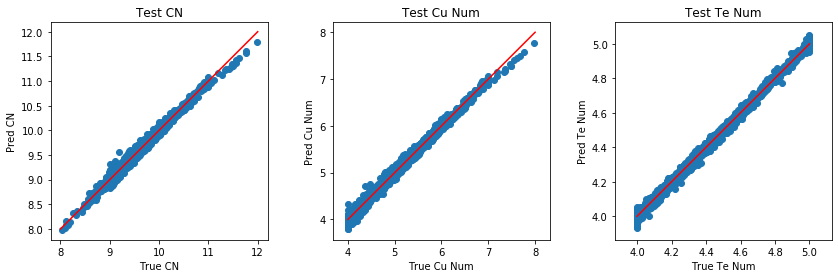

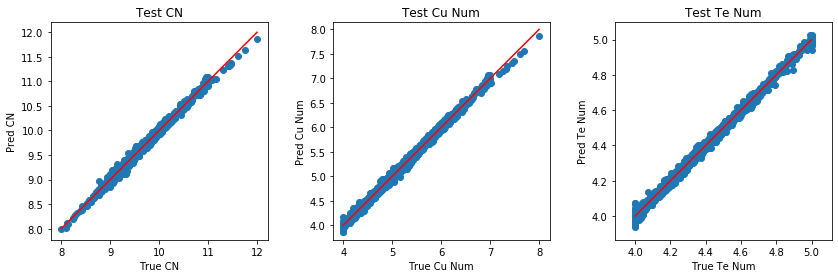

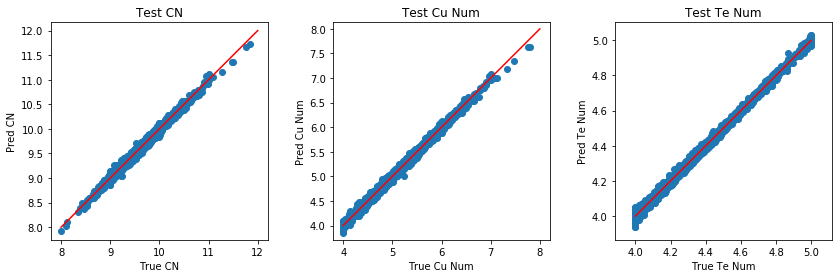

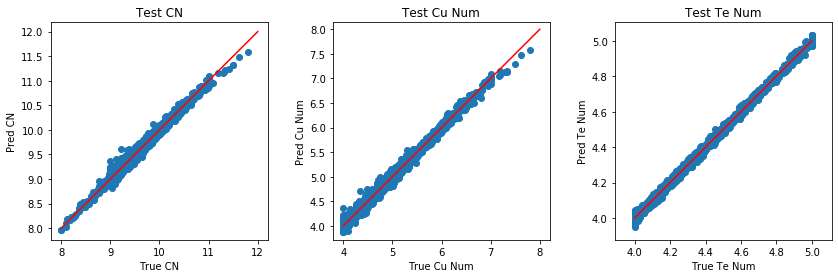

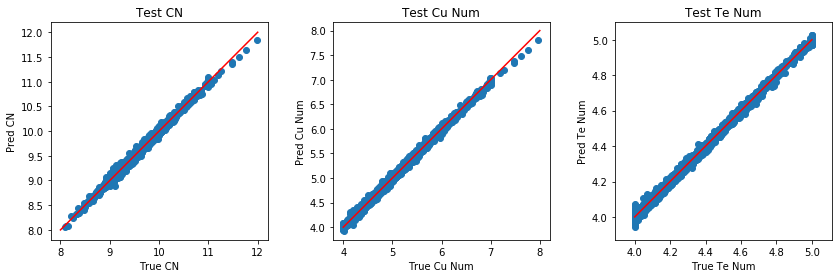

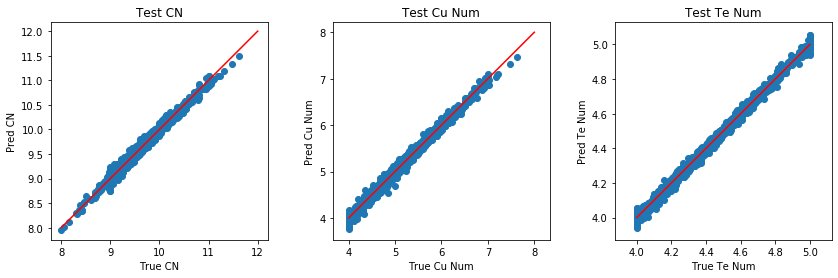

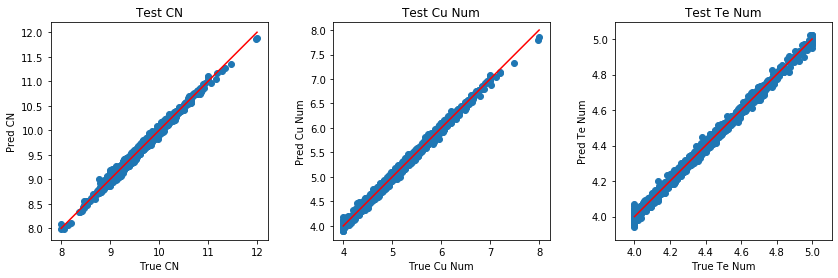

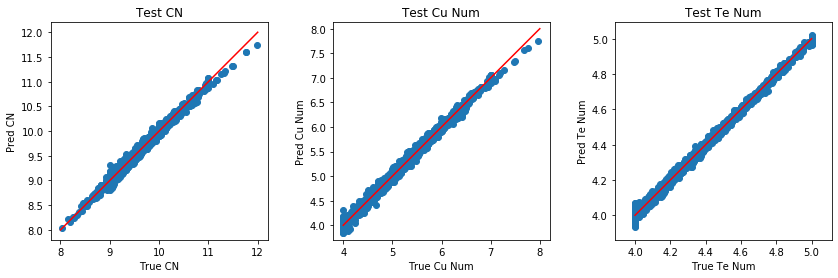

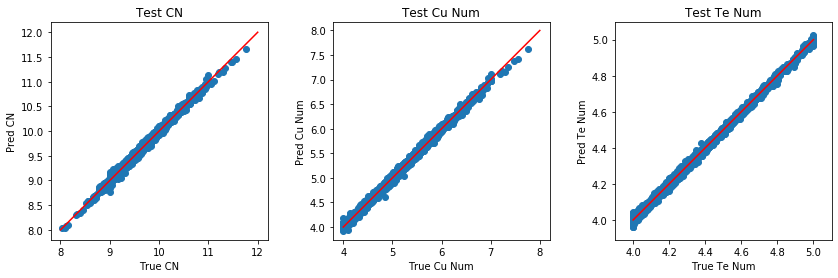

In [10]:
average_scores_1_2(iterations, df, Noise_STD)

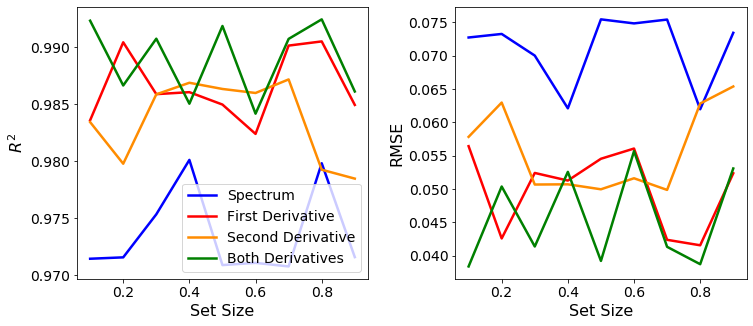

In [15]:

plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_CN_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_CN_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_CN_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_CN_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Percent Test', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_CN_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_CN_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Percent Test', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

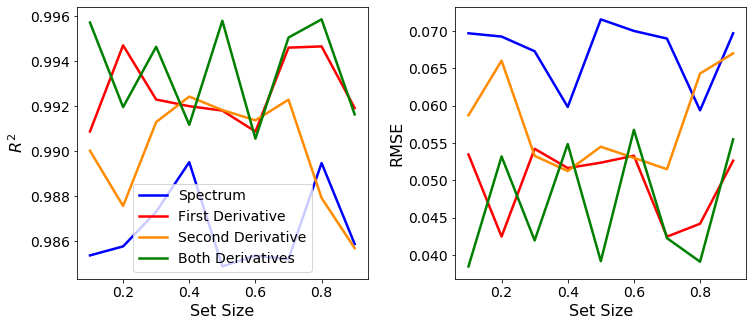

In [16]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_Cu_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_Cu_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_Cu_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_Cu_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_Cu_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_Cu_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

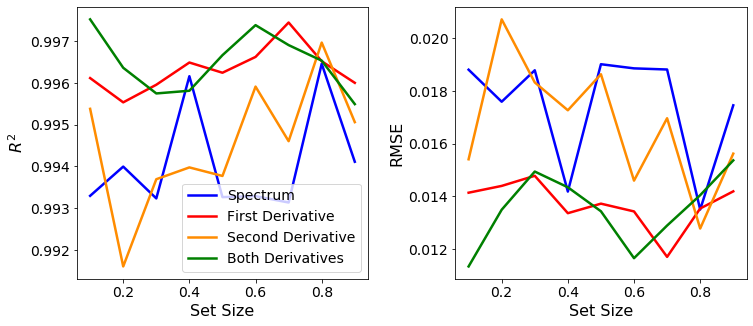

In [17]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, score_Te_master_list, c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, score_Te_master_list_1, c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, score_Te_master_list_2, c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, score_Te_master_list_1_2, c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Set Size', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, rmse_Te_master_list, c='blue', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_1, c='red', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_2, c='darkorange', lw=2.5)
ax2.plot(size_list, rmse_Te_master_list_1_2, c='green', lw=2.5)
ax2.set_xlabel('Set Size', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()